In [1]:
import numpy
import matplotlib.pyplot as plt
import tamaas

from numpy import pi
from IPython.display import display, Latex

In [20]:
%%capture
from tamaas.dumpers import NumpyDumper

In [3]:
plt.rc('figure', dpi=100)

# Elastic Contact with Periodic Surface

*Before you begin: if you've downloaded this notebook, make sure you have the dependencies installed. `python3 -m pip install --user -r requirements.txt` should set you up nicely.*


In this notebook, we'll see how to setup an elastic contact simulation with Tamaas. We'll start with generating a 2D sinusoidal surface:

$$ h(x, y) = \sin\left(2\pi \frac{x}{L}\right)\sin\left(2\pi \frac{y}{L}\right) $$

Here, the period $L$ describes the physical size of the domain. Let's start with generating the coordinate space with as Numpy arrays.

In [4]:
L = 1.   # physical size of the domain (often convenient to set to 1)
N = 256  # number of points in each direction

x = numpy.linspace(0, L, N, endpoint=False)
y = numpy.linspace(0, L, N, endpoint=False)

Notice that we have asked Numpy to generate a coordinate space without the value $L$ (the end of the interval). This is due to how periodicity is handled in Tamaas (and in fast-Fourier transform libraries in general): periodic images are not stored.

We now create our surface array.

In [5]:
xx, yy = numpy.meshgrid(x, y, indexing='ij')  # Creates a cartesian coordinate space

surface = numpy.sin(2 * pi * (xx / L)) * numpy.sin(2 * pi * (yy / L))

Let's plot our surface.

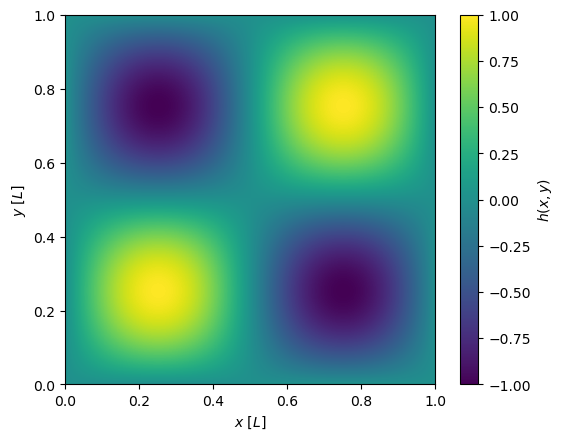

In [6]:
fig, ax = plt.subplots()

image = ax.imshow(surface, extent=(0, L, 0, L), origin='lower')

ax.set_xlabel('$x$ [$L$]')
ax.set_ylabel('$y$ [$L$]')

fig.colorbar(image).set_label('$h(x, y)$')

## Setting up the model

Now that we have a contact surface, let us create the model. For this we use the `tamaas.ModelFactory.createModel()` function. We have to give it the model type, which in our example is `tamaas.model_type.basic_2d`, which means that the model will only have normal pressure and normal displacement degrees of freedom, and that we only care about surface displacements.

We also have to supply the extent of the domain for the model, and the number of points in each direction.

In [7]:
model = tamaas.ModelFactory.createModel(tamaas.model_type.basic_2d, [L, L], [N, N])

model.E = 1.    # Young's modulus
model.nu = 0.3  # Poisson's coefficient

print(model)

Model<basic_2d> (E = 1, nu = 0.3)
  - domain = [1, 1]
  - discretization = [256, 256]
  - registered fields = [displacement, traction]
  - registered operators = [deviatoric, von_mises, eigenvalues, hooke]


As you might notice above, we set $E = 1$. There is no unit management in Tamaas. Whichever unit you choose to assign to $E$ will be the unit of all stress quantities.

## Setting up the solver

Finally, we have to set up the contact solver. For normal, elastic contact, the best class for the job is `tamaas.PolonskyKeerRey`. It is quite flexible in its architecture and can handle custom terms to the function it is trying to minimize. This is very handy for adhesive contact, where one may wish to change the adhesive potential. However, for the puroses of this tutorial, we'll stick with the default options of the solver, which are perfect for contact without adhesion.

In [8]:
tolerance = 1e-9  # solver tolerance, usually around 1e-9 adhesion-less contact
solver = tamaas.PolonskyKeerRey(model, surface, tolerance)

## Computing contact solutions

Finally, we can compute contact solutions with the `solve()` method of the solver, which takes an applied normal pressure (by default) as parameter. The contact solution is solved with this pressure as the target mean pressure (i.e. a form of Neumann boundary condition).

In [9]:
P = 0.6
solver.solve(P)

 Iter          Cost_f           Error
    0   -4.956283e-01    8.985970e-01
   62   -5.547696e-01    9.620612e-10


9.620611779030431e-10

You may see above an informative output of the solver in red. This is useful if one wishes to track the progress of the solver, but can be turned off with `tamaas.set_log_level(tamaas.LogLevel.Warning)`, which would only output warning messages. The updated frequency can be adjusted with `solver.dump_freq`.

## Plotting results

We can now access the contact solution with the `model` object. The properties `model.displacement` and `model.traction` are self explanatory.

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plotting pressure
image = axs[0].imshow(model.traction / (model.E / (1 - model.nu**2)), extent=(0, L, 0, L), 
                      origin='lower', cmap='magma_r')
fig.colorbar(image, ax=axs[0]).set_label(r'$p$ $\left[\frac{E}{1-\nu^2}\right]$')
axs[0].set_title('Pressure')

# Plotting displacement
image = axs[1].imshow(model.displacement / L, extent=(0, L, 0, L), origin='lower', cmap='viridis_r')
fig.colorbar(image, ax=axs[1]).set_label(r'$u$ [$L$]')
axs[1].set_title('Displacement')

for ax in axs:
    ax.set_xlabel('$x$ [$L$]')
    ax.set_ylabel('$y$ [$L$]')

The objects `model.traction` and `model.displacement` are just Numpy arrays and can be easily manipulated. For example, we can verify our average applied pressure to check if it corresponds to what we set.

In [11]:
mean_pressure = numpy.mean(model.traction)

display(Latex('We set $P = {:.1f}$, and we got $\\bar{{p}} = {:.1f}$!'.format(P, mean_pressure)))

<IPython.core.display.Latex object>

## Saving results

To save a model, the simplest method is to use a dumper from the `tamaas.dumpers` module. Some dumpers in there require external dependencies other than Numpy, but they dump to files which can be used by other applications. Let's keep it simple for now and dump our model to a Numpy formated file. We first need to create the dumper.

In [12]:
dumper = NumpyDumper('my_model_dump', all_fields=True)

When calling the constructor of a dumper, we can either give the names of the fields we wish to include in the files or supply `all_fields=True` to dump every field in the model (here the displacements, tractions and the gap, i.e. the surface separation). Now we can write the files very simply.

In [13]:
dumper << model

Calling a dumper with a model automatically creates a folder that will contain the dump files. Each subsequent dump (with the same dumper) creates a new, numbered file. We can use several dumpers for the same model.

In [14]:
# Register the dumpers with the model
model.addDumper(dumper)  # repeat with other dumpers

# Calls each registered dumper in succession
model.dump()

You should now see two Numpy dumps. At any time, you can inspect the model to see the dumpers that are registered with it.

In [15]:
print(model)

Model<basic_2d> (E = 1, nu = 0.3)
  - domain = [1, 1]
  - discretization = [256, 256]
  - registered fields = [gap, displacement, traction]
  - registered operators = [Westergaard::neumann, westergaard_neumann, westergaard_dirichlet, deviatoric, von_mises, eigenvalues, hooke]
  - 1 registered dumpers


## Fields

You may have noticed that our model has a field, the `gap`, which was not registered at the time we created the model. This field is automatically created by the solver and registered with the model. Since it is not a default field, there are no properties to access it, but the model provides a `[]` operator, like a Python dictionary, just for this situation. Let's plot the gap.

Text(0, 0.5, '$y$ [$L$]')

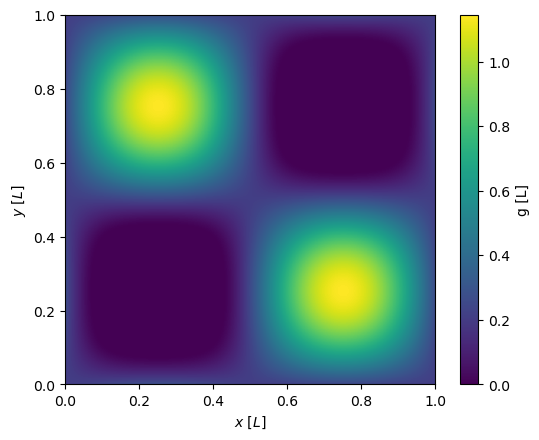

In [16]:
fig, ax = plt.subplots()

image = ax.imshow(model['gap'] / L, extent=(0, L, 0, L), origin='lower')
fig.colorbar(image).set_label('g [L]')

ax.set_xlabel('$x$ [$L$]')
ax.set_ylabel('$y$ [$L$]')

Any field registered in the model can be accessed with `model['field_name']`. You can also register your own fields, just like a Python dictionary. To conclude this tutorial, let's register the surface we have created.

In [17]:
model['surface'] = surface

print(model)

Model<basic_2d> (E = 1, nu = 0.3)
  - domain = [1, 1]
  - discretization = [256, 256]
  - registered fields = [surface, gap, displacement, traction]
  - registered operators = [Westergaard::neumann, westergaard_neumann, westergaard_dirichlet, deviatoric, von_mises, eigenvalues, hooke]
  - 1 registered dumpers


## Computing several contact solutions

The module `tamaas.utils` provides a convenient function `load_path`, which returns a generator holding solutions of a sequence of applied loads. This makes it convenient to compute quantities from the model and removes boilerplate code. Below is an example of contact area computation, max pressure and perimeter.

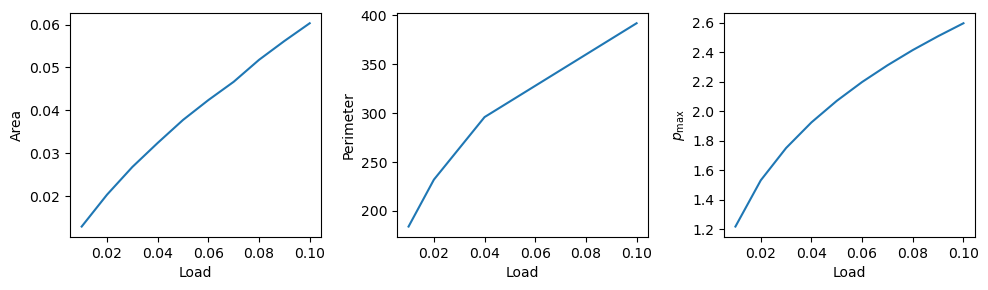

In [18]:
# Import load_path
from tamaas.utils import load_path

# Defining the loading sequence
loads = numpy.linspace(0.01, 0.1, 10)

# Computing contact areas with a generator expression
# Note: the callback argument is useful to dump model in generator expressions
areas = numpy.fromiter((tamaas.Statistics2D.contact(m.traction)
                        for m in load_path(solver, loads, callback=model.dump)), float)

# Computing perimeter and max pressure with the same computations
perimeters, pmaxs = [], []

# Now using a for loop, better suited for verbose processing of models
# Note: this recomputes contact solutions
for model in load_path(solver, loads):
    perimeter = sum(c.perimeter for c in tamaas.FloodFill.getClusters(model.traction > 0, False))
    pmax = model.traction.max()
    
    perimeters.append(perimeter)
    pmaxs.append(pmax)
    
# Plotting results
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

for ax, data, label in zip(axs, (areas, perimeters, pmaxs), ("Area", "Perimeter", "$p_\\mathrm{max}$")):
    ax.plot(loads, data)
    ax.set_xlabel("Load")
    ax.set_ylabel(label)
    
fig.tight_layout()